# Bayesian Baseball Monkeys

The MARCEL baseball projection model, developed by Tom Tango, is a deliberately simple forecasting system for Major League Baseball (MLB) player performance. Named humorously after Marcel the Monkey, it aims to represent the "minimum level of competence" that should be expected from any forecaster. 

> Actually, it is the most basic forecasting system you can have, that uses as little intelligence as possible. So, that's the allusion to the monkey. It uses 3 years of MLB data, with the most recent data weighted heavier. It regresses towards the mean. And it has an age factor. -- *Tom Tango*

Yet, this minimalist approach makes it a transparent, reliable starting point for player projections without requiring extensive computational resources or complex algorithms.

![monkey](assets/Marcel-the-Monkey.png)

### Key Features of the MARCEL Model

1. **Data Utilization**:
   - The model uses three years of MLB data, with the most recent year weighted more heavily. This approach ensures that the projections are based on a player's recent performance while still considering their historical data.

2. **Regression to the Mean**:
   - MARCEL incorporates a regression towards the mean, which helps to temper extreme performances and provide more balanced projections.

3. **Age Factor**:
   - The model includes an age factor to account for the natural aging process of players, which can affect their performance.


Here is the recipe for the model, taken from his website describing the 2004 version of the model:

> 1 - Weight each season as 5/4/3. 2003 counts as "5" and 2001 counts as "3".
> 
> 2 - Determine each player's league average. I removed all pitchers' hitting totals from the league average. I lumped in AL and NL together. I weighted the player's league average using the 5/4/3 process and that's player's PA for that season. I then forced in that player's league average to come in at a total of 1200 PA for each player (2 weights x 600 PA). This is the regression towards the mean component.
> 
> 3 - Add the above two.
> 
> 4 - Determine the projected PA = 0.5 * 2004PA + 0.1 * 2003PA + 200. I take the result of #3, and > prorate it to this projected PA.
> 
> 5 - Determine an age adjustment. Age = 2004 - yearofbirth. If over 29, AgeAdj = (age - 29) * .003. > If under 29, AgeAdj = (age - 29) * .006. Apply this age adjustment to the result of #4.
> 
> 6 - Rebaseline the results against an assumed league average of 2003.

This description relates speficically to batter data, but the methodology can be applied to any annual player statistics.


## A Bayesian Marcel?

An interesting exercise is to consider how we might implement an analog of MARCEL using Bayesian methods. By incorporating a Bayesian framework, we can introduce uncertainty estimates into the projections, which can be valuable for decision-making and risk assessment. 

In the spirit of MARCEL, the goal here is not to have a sophisticated model for making accurate projections, but rather to have a simple, general purpose model that can be used to project arbitrary metrics, usually intended to provide baseline one-year-ahead projections. The only difference is that we will now have probabilistic uncertainty estimates around the resulting projections.

To this end, the three core components have been adapted as follows:

1. The data weights for previous seasons are estimated from the data.
2. A triangular aging function, whose midpoint is estimated from the data.
3. A hierarchical random effect for mean regression when data are sparse.

## Case study: Hard hit rate

As a motivating example, we will look at projecting batter hard hit rate. Hard hit rate (Hard%) measures the percentage of batted balls that are hit with exit velicities exceeding 95 miles per hour. Developed by Sports Info Solutions, it was originally based on a subjective classification of batted balls as either "soft," "medium," or "hard" hit. The introduction of Statcast data (via HitFX, Trackman, and now Hawkeye) allowed batted ball exit velocities to be measured directly. Hard hit rate is often a leading indicator of  performance in other statistics such as HR/FB rate and BABIP, while for pitchers, it can help explain their HR/FB rate and xFIP. The league average hard hit rate is around 35%, so consistently exceeding this mark is generally considered positive for hitters and concerning for pitchers.

![](assets/hardhit.jpeg)

**Image: mlb.com**


## Data Preparation

We will use the `pybaseball` package to obtain the data for the model. The package provides a convenient interface to the Statcast data, which contains detailed player statistics for each season. 

We will use hard hit rates for years 2020 trhough 2022 to fit data observed in 2023, and then use the resulting parameter estimates to predict the 2024 rate from seasons 2021 through 2023. Therefore, we will query all batter data form 2020 through the games in 2024 at the time of this writing.

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import pytensor.tensor as pt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

data = batting_stats(2020, 2024, qual=1)

hard_hit_subset = data[["Name", "Season", "Team", "Age", "HardHit", "Events"]].copy().reset_index(drop=True)
hard_hit_subset.shape

(3550, 6)

So, we will be using years 2020 to 2022 to fit to 2023 outcomes, where the target variable is observed hard hits (`HardHit`). The sample size will be the corresponding number of batted balls (`Events`) in each year. 

For convenience, we are using players who have complete data over all 4 seasons.

We need to do a little bit of data processing. Specifically, we create index values for each batter, age and season in the dataset, and then pivot the data so that we have a column representing each year of data.

In [78]:
# batter_idx, batters = hard_hit_subset['Name'].factorize()
# hard_hit_subset["batter_idx"] = batter_idx

# age_idx, ages = hard_hit_subset['Age'].factorize(sort=True)
# hard_hit_subset["age_idx"] = age_idx

# season_idx, seasons = hard_hit_subset['Season'].factorize(sort=True)
# hard_hit_subset["season_idx"] = season_idx

hard_hit_by_season = (
    hard_hit_subset.pivot_table(index=['Name'], values=["Events", "HardHit", "Age"], columns=['Season'])
    .dropna(subset=[('HardHit', 2020), ('HardHit', 2021),
                    ('HardHit', 2022),
                    ('HardHit', 2023)])
    # .reset_index()
)
hard_hit_by_season

Age                         Events                       \
Season           2020  2021  2022  2023  2024   2020   2021   2022   2023   
Name                                                                        
A.J. Pollock     32.0  33.0  34.0  35.0   NaN  153.0  306.0  395.0  103.0   
Aaron Hicks      30.0  31.0  32.0  33.0  34.0  131.0   80.0  278.0  201.0   
Aaron Judge      28.0  29.0  30.0  31.0  32.0   70.0  397.0  404.0  240.0   
Abraham Almonte  31.0  32.0  33.0  34.0   NaN    7.0  111.0   23.0    7.0   
Abraham Toro     23.0  24.0  25.0  26.0  27.0   64.0  283.0  263.0   13.0   
...               ...   ...   ...   ...   ...    ...    ...    ...    ...   
Yordan Alvarez   23.0  24.0  25.0  26.0  27.0    7.0  395.0  371.0  322.0   
Yu Chang         24.0  25.0  26.0  27.0   NaN    7.0  169.0  111.0   73.0   
Yuli Gurriel     36.0  37.0  38.0  39.0   NaN  189.0  474.0  475.0  258.0   
Zach McKinstry   25.0  26.0  27.0  28.0  29.0    4.0  111.0  116.0  356.0   
Zack Collins     25.0  26.0  27.0  28.0   NaN   11.0  127.0   57.0    2.0   

                       HardHit                              
Season            2024    2020   2021   2022   2023   2024  
Name                                                        
A.J. Pollock       NaN    66.0  144.0  166.0   42.0    NaN  
Aaron Hicks       34.0    50.0   31.0   92.0   59.0   12.0  
Aaron Judge      227.0    29.0  230.0  246.0  154.0  139.0  
Abraham Almonte    NaN     1.0   46.0    7.0    5.0    NaN  
Abraham Toro     225.0    18.0   95.0   78.0    4.0   65.0  
...                ...     ...    ...    ...    ...    ...  
Yordan Alvarez   273.0     5.0  214.0  222.0  168.0  126.0  
Yu Chang           NaN     1.0   57.0   41.0   28.0    NaN  
Yuli Gurriel       NaN    67.0  196.0  168.0   89.0    NaN  
Zach McKinstry    96.0     2.0   39.0   35.0  118.0   32.0  
Zack Collins       NaN     6.0   56.0   23.0    2.0    NaN  

[332 rows x 15 columns]

Let's start by adding our data to the model. Using `Data` objects in our model graph will permit us to easily generate predictions for new data.

In [84]:
fit_seasons = [2020, 2021, 2022]

coords = {
    'batter': hard_hit_by_season.index.to_numpy(), 
    'season': fit_seasons,
}

with pm.Model(coords=coords) as marcel:

    # age_x = pm.Data("age_x", hard_hit_by_season["Age"][fit_seasons].to_numpy().astype(np.float32))
    age_y = pm.Data("age_y", hard_hit_by_season["Age"][2023].to_numpy().astype(np.float32))
    events_x = pm.Data("events_x", hard_hit_by_season["Events"][fit_seasons].to_numpy().astype(np.int32))
    hard_hit_x = pm.Data("hard_hit_x", hard_hit_by_season["HardHit"][fit_seasons].to_numpy().astype(np.int32))
    events_y = pm.Data("events_y", hard_hit_by_season["Events"][2023].to_numpy().astype(np.int32))
    hard_hit_y = pm.Data("hard_hit_y", hard_hit_by_season["HardHit"][2023].to_numpy().astype(np.int32))

## Model formulation

Let's start with the **mean regression** component of the model. 

If we look at the distribution of empirical rates in the dataset, we can see a few issues that can largely be associated with small sample sizes: several zero and one counts from players with only a handfull of batted balls, and generally longer tails on both sides with unsustainable values.

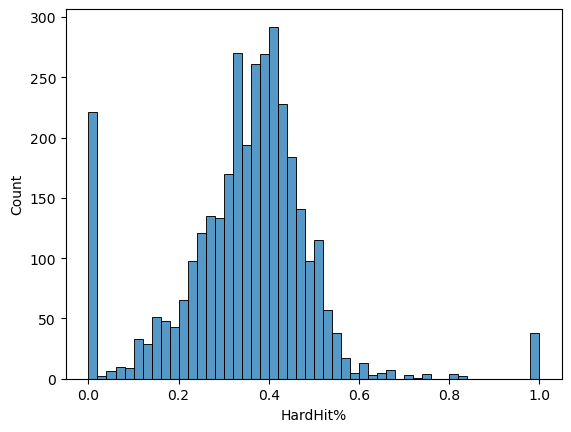

In [85]:
sns.histplot(data=data, x="HardHit%");

Tango dealt with this proble by calculating a weighted average of each player's observed data and the league average. Here, we will use a hierarchical model to partially pool the data according to the relative quantity of data for each player-season. Since we are modeling the number of hard hits per batted balls, a binomial sampling distribution with beta-distributed rates is appropriate.

As we were told that the league average hard hit rate is around 35 percent, we can take advantage of the mean-variance parameterization of the beta distributtion in PyMC:

$$\Large p_i \sim Beta(\mu_p, \sigma_p)$$

Then, we can assign a weakly-informative priors to $\mu_p$ and $\sigma_p$. 

In [86]:
with marcel:

    # Empirical rates, regressed to mean with beta-binomial
    mu_p = pm.Beta("mu_p", 35, 65)
    sigma_p = pm.Uniform("sigma_p", 0, 0.5)
    p = pm.Beta("p", mu=mu_p, sigma=sigma_p, dims=("batter", "season"))
    pm.Binomial("rate_like", n=events_x, p=p, observed=hard_hit_x)

The core of the Marcel projection model is the weighted averaging of previous seaons' observations. While the Tango model hard-coded a 5/4/3 weighting scheme, we will estimate optimal weights from the data. Thus, we are looking to project $p_i^{(t-1)}$ via:

$$\Large p_i^{(t+1)} = w_0 p_i^{(t)} + w_1 p_i^{(t-1)} + w_2 p_i^{(t-2)}$$

where the $p_i$ are the latent partially-pooled rates from above. 

The set of weights are modeled with a Dirichlet distribution:

$$\Large \{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$$

In keeping with the spirit of the original model, we will allocate hyperpriors $\phi = (5, 4, 3)$.

<!-- For pitcher $i$ having observed values of some quantity of interest in three consecutive years $y_i^{(t)}, y_i^{(t-1)}, y_i^{(t-2)}$ we are predicting $y_i^{(t+1)}$ via:

$$\theta_i^{(t+1)} = \mu_i + w_0 (\theta_i^{(t)}) + w_1 (\theta_i^{(t-1)}) + w_2 (\theta_i^{(t-2)}) + $$

where $\{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$ are constrained to be ordered and the $\theta_i$ are partially pooled observations to regress extreme values. For Gaussian data, the likelihood is:

$$y_i^{(t)} \sim N(\theta_i^{(t)}, \sigma)$$

For other types of data, this likelihood may be binomial or Poisson.



All inputs are automatically standardized to aid in convergence. -->

In [87]:
with marcel:

    # Marcel weights
    w = pm.Dirichlet(
        "w",
        a=np.array([3, 4, 5]),
        dims='season'
    )

    p_proj = p @ w


Finally, we implement the aging effect as a simple triangular (piecewise-linear) model on the logit scale, where the hard hit rate increases up to some "peak" age, and then decreases at the same rate thereafter. Both the value of the slope and the peak age are parameters of the model.

$$\Large \alpha_i^{(t+1)} =  \beta (a_0 - a_i^{(t+1)})$$
$$\Large \beta \sim N(0, 1)$$
$$\Large a_0 \sim U(a_{\min}, a_{\max})$$

In [88]:
with marcel:

    # Coefficient for triangular aging
    beta = pm.Normal("beta")
    # Estimate of peak age
    peak_age = pm.Uniform("peak_age", data.Age.min(), data.Age.max())    

    age_effect = beta * (peak_age - age_y)

Thus, the projected rate is the age-adjusted weighted average of the latent rates over the three-year period, appropriately transformed to stay on the unit interval. 

In [89]:

with marcel:
    
    projected_rate = pm.Deterministic(
        "projected_rate",
        pm.math.invlogit(pm.math.logit(p_proj) + age_effect),
        dims="batter"
    )

    # # Likelihood of observed hard hits
    pm.Binomial("prediction", n=events_y, p=projected_rate, observed=hard_hit_y, dims="batter")

    

We will estimate the model using Markov chain Monte Carlo (MCMC) sampling, specifically the No-U-Turn Sampler (NUTS) algorithm. For the sake of performance, we will use the Numpyro implementation.

In [90]:
with marcel:
    trace = pm.sample(nuts_sampler="numpyro", target_accept=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

You want to keep an eye on this output for any warning messages that may require additional intervention in order to improve the model. This example should run fine under the default conditions.

## Model Checking

Even in the absence of warnings, its always important to check your model. In model checking, we want to know at least two things: did the model fitting algorithm work, and does the model fit the data adequately.

For the first part, we want to do **convergence diagnostics** because we have used a stochastic sampling approach (MCMC) to fit the model. That is, we want some assurance that the sampler *converged* to what the model specifies as the posterior distribution. This implies that the algorithm has had a chance to adequately explore the parameter space of the model. 

The `az.plot_energy` function will produce an **energy plot** of the fiitted model that gived a visual indication as to whether the model has been able to freely explore the parameter space. You will see two distributions: a marginal energy distribution and an energy transition distribution. Its not important to understand exactly what these are, but you are looking for these two distribtions to mostly overlap, as they should below. When they do not, the difference is usually rather dramatic. The plot below should be close enough.

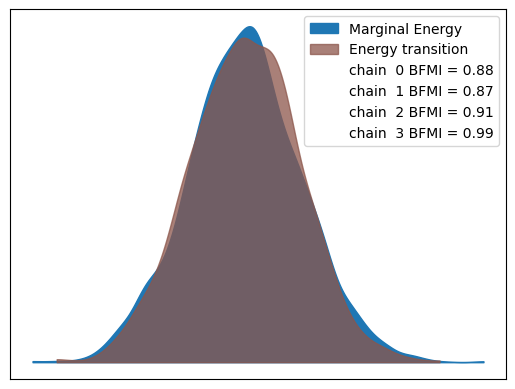

In [99]:
az.plot_energy(trace);

If we are satisfied that the model has converged, we can move on to the model fit. This is largely the same idea as a model **calibration** check: seeing whether the model predictions correspond adequately to observed values. Since we have a Bayesian model, we can use **posterior predictive checks** for this. This involves simulating several datasets from the model, and comparing the simulated datasets to the actual observed data (in this case, the data used to fit the model). If the model fits, we would expect the observed data to be indistinguishable from some random draw from the model.

The `check_calibration` method automates this for you, generating a visual check whereby a cloud of lines representing a thousand or so simulated datasets are plotted as blue lines alongside the observed data as a thick black line. 

Sampling: [prediction, rate_like]


Output()

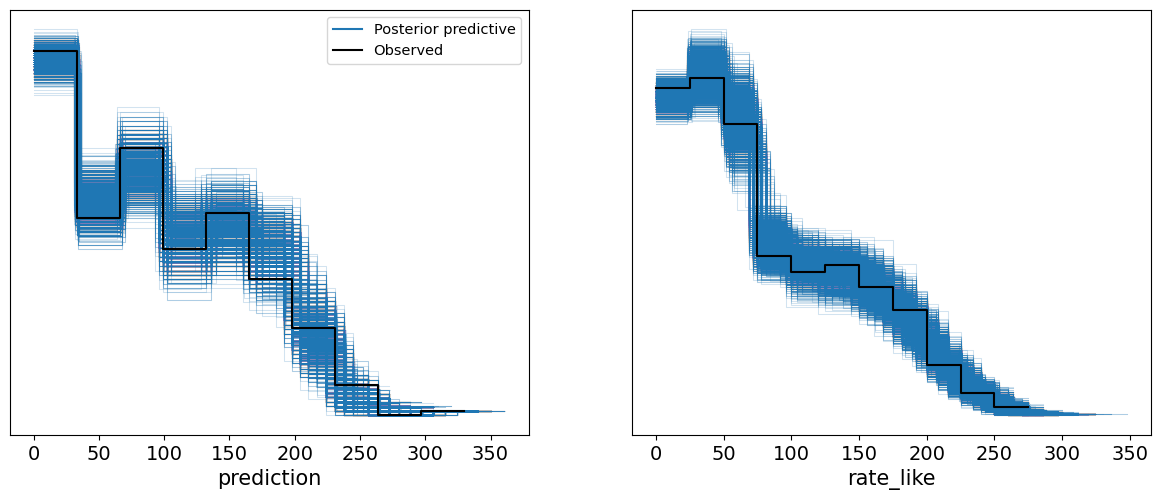

In [ ]:
with marcel:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_ppc(trace, mean=False);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

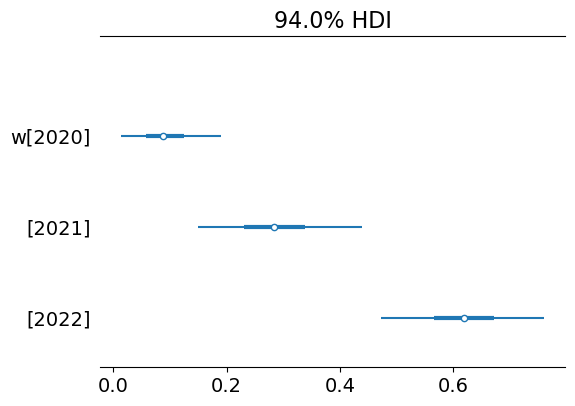

In [92]:
az.plot_forest(trace, var_names='w', combined=True)

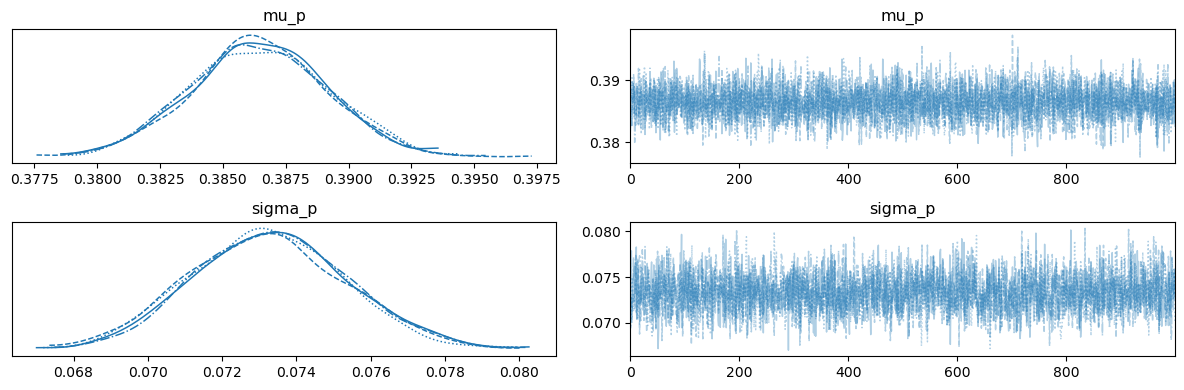

In [93]:
az.plot_trace(trace, var_names=['mu_p', 'sigma_p'])
plt.tight_layout();

array([[<Axes: title={'center': 'peak_age'}>,
        <Axes: title={'center': 'peak_age'}>]], dtype=object)

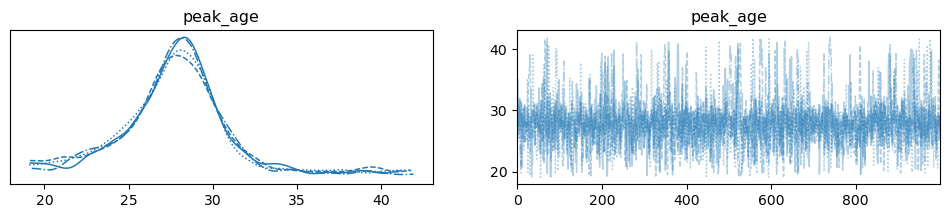

In [94]:
az.plot_trace(trace, var_names='peak_age')

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

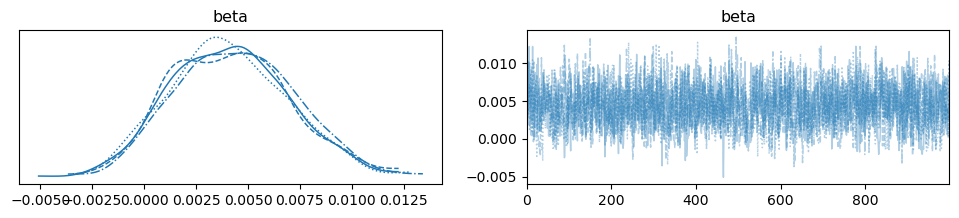

In [95]:
az.plot_trace(trace, var_names='beta')

## Generating Projections

Once we have checked the model and are comfortable with the evaluation, we can use it to generate projections for future seasons. We can predict the hard hit rate for the current season, using data from 2021 through 2023. Here, we are not estimating anything; we are merely applying the fitted model parameters to a new set of inputs.

In PyMC, the `set_data` function is used to swap in the new data, after which we can use the `sample_posterior_predictive` function to generate predictions.

In [101]:
pred_seasons = [2021, 2022, 2023]

with marcel:
    pm.set_data(
        {'age_y': hard_hit_by_season["Age"][2024].to_numpy().astype(np.float32),
         'hard_hit_x': hard_hit_by_season["HardHit"][pred_seasons].to_numpy().astype(np.int32),
         'events_x': hard_hit_by_season["Events"][pred_seasons].to_numpy().astype(np.int32)
        }
    )

    pm.sample_posterior_predictive(trace, var_names=['expected_rate'], predictions=True, extend_inferencedata=True)

Sampling: []


Output()

In [102]:
p_obs = (hard_hit_by_season['HardHit'] / hard_hit_by_season['Events'])[2024].fillna(0)

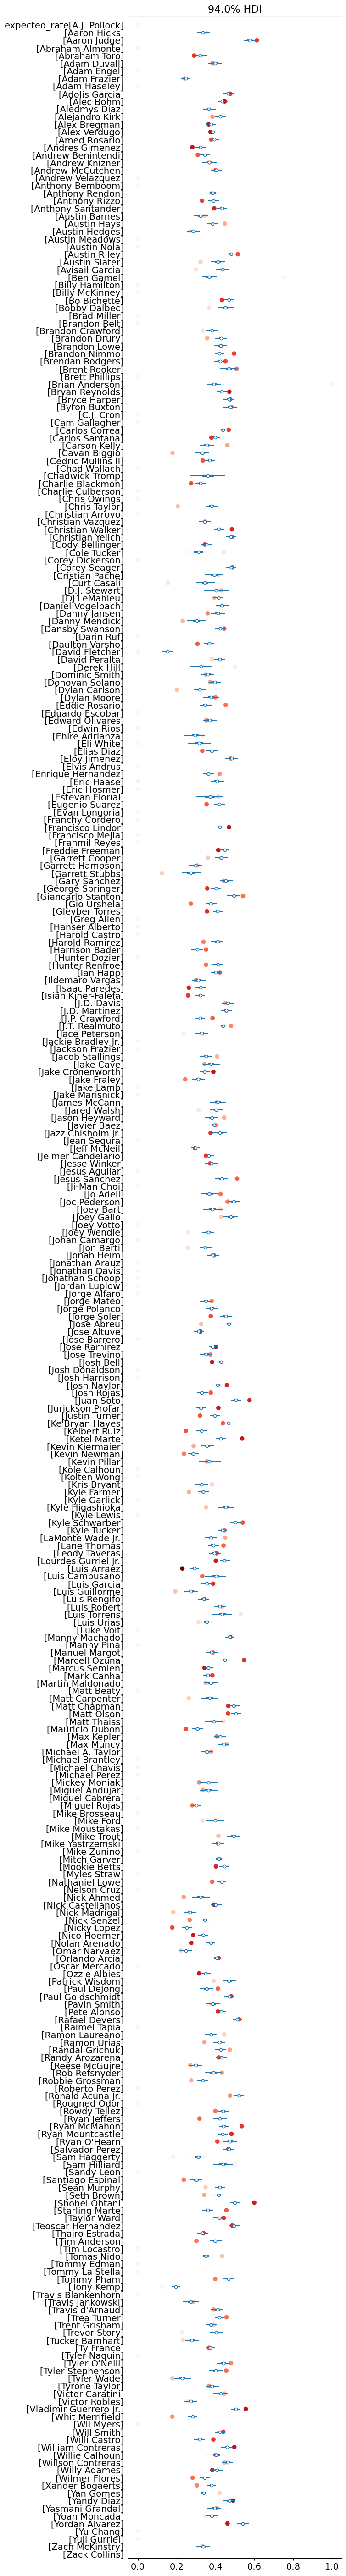

In [103]:
axes = az.plot_forest(trace.predictions['expected_rate'], combined=True, figsize=(6, 72))
axes[0].scatter(p_obs.values[::-1], axes[0].get_yticks(), c=list(hard_hit_by_season.Events[2024].fillna(0).values[::-1]), cmap='Reds');

In [108]:
pd.DataFrame(p_obs)

,2024
Name,
A.J. Pollock,0.000000
Aaron Hicks,0.352941
Aaron Judge,0.612335
Abraham Almonte,0.000000
Abraham Toro,0.288889
...,...
Yordan Alvarez,0.461538
Yu Chang,0.000000
Yuli Gurriel,0.000000


In [106]:
trace.predictions['expected_rate'].mean(dim=['chain', 'draw'])

<xarray.DataArray 'expected_rate' (batter: 332)> Size: 3kB
array([       nan, 0.33408128, 0.57576493,        nan, 0.32017761,
       0.39895462,        nan, 0.24648201,        nan, 0.46369788,
       0.43493475, 0.36563421, 0.42486581, 0.37614588, 0.38539081,
       0.39274019, 0.32192884, 0.34504531, 0.36822953, 0.403024  ,
              nan,        nan, 0.38594292, 0.38833232, 0.4341982 ,
       0.32197789, 0.38380044, 0.2839719 ,        nan,        nan,
       0.48017668, 0.41213582, 0.43594779, 0.36653621,        nan,
              nan, 0.46961594, 0.45033344,        nan,        nan,
       0.38050924, 0.42932188, 0.42641829, 0.41935869, 0.42341814,
       0.4682462 ,        nan, 0.39161105, 0.43209989, 0.46823929,
       0.47597243,        nan,        nan, 0.4390734 , 0.39772352,
       0.35447552, 0.33258452, 0.37002595,        nan, 0.36073818,
       0.32226574,        nan,        nan, 0.37880742,        nan,
       0.34462481, 0.41677297, 0.47966459, 0.35247792, 0.31326461,
              nan, 0.48147716, 0.39235906, 0.346663  , 0.40477965,
       0.41399217, 0.43414495, 0.41178979, 0.30333462, 0.42484562,
              nan, 0.36701747, 0.15204091, 0.42083027, 0.32489852,
       0.36093538, 0.39647761, 0.31843428, 0.37698764, 0.34647989,
              nan, 0.37072757,        nan, 0.29547952, 0.31603499,
       0.38199516, 0.48402816,        nan, 0.36287281, 0.4070671 ,
...
       0.39871684,        nan, 0.4919657 , 0.41389212,        nan,
       0.41686675, 0.4451569 ,        nan, 0.43142722,        nan,
       0.32357795, 0.40072349, 0.26814619, 0.34699172, 0.25152782,
       0.33751643, 0.37653694, 0.24593284, 0.4056732 ,        nan,
       0.34886794, 0.47031249, 0.35329072, 0.47206006, 0.38705785,
       0.42963577, 0.5105072 ,        nan, 0.37700426, 0.42060231,
       0.42570626, 0.43071677, 0.29842516, 0.38859403, 0.33553808,
              nan, 0.52125074,        nan, 0.43954549, 0.42090404,
       0.44185072, 0.43575993, 0.47478462, 0.46970268, 0.31085778,
       0.43840192,        nan, 0.30118986, 0.42257194, 0.4158709 ,
       0.5007174 , 0.3590963 , 0.41999329, 0.49537025, 0.33154585,
       0.39828272,        nan, 0.35139341,        nan,        nan,
       0.46656857, 0.19431118,        nan, 0.27044241, 0.40948482,
       0.42021502, 0.37651962, 0.40420259, 0.27778834, 0.37270592,
              nan, 0.4411892 , 0.39952268, 0.22814006, 0.38115525,
       0.42579653, 0.27252847, 0.50372569, 0.28179468,        nan,
       0.42286821, 0.31804847, 0.46030321, 0.40389909, 0.46241141,
       0.40736915, 0.34397352, 0.3792334 , 0.33813478, 0.47069273,
       0.39636309, 0.38133256, 0.54058806,        nan,        nan,
       0.33571986,        nan])
Coordinates:
  * batter   (batter) <U21 28kB 'A.J. Pollock' 'Aaron Hicks' ... 'Zack Collins'

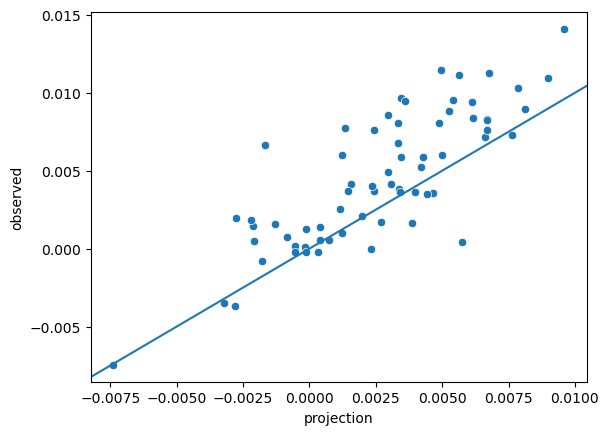

In [19]:
projection = pd.DataFrame(dict(projection=trace.predictions['expected_rate'].mean(), observed=y.loc[pred_pitchers].values))
ax = sns.scatterplot(x='projection', y='observed', data=projection)
ax.axline((0, 0), slope=1);

## When Things Go Wrong

With such a simple model that attempts to project almost anything, inevitably things will go wrong with certain datasets. The first place to look for symptoms of a problem are in the warnings during model fitting. For example, you may read something along the lines of:

> UserWarning: Chain 0 contains 6 diverging samples after tuning. Increase `target_accept` or reparameterize.

This means that the model is (occasionally) having trouble sampling from the model, which results in a **diverging** sample. If this happens only a few times (6 is not many!) things are probably okay, but if there are hundreds or even entirely divergent samples, you will not be able to reliably use inference from the model. 

The underlying PyMC model tries to give advice when it can: while you cannot reparameterize this model, it is possible to change the `target_accept` parameter by passing it to `fit`.  

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", target_accept=0.99)

`target_accept` is the target acceptance rate of the MCMC algorithm, which by default is 0.8. For difficult models, upping this value to 0.9, 0.95 or 0.99 can sometimes solve this issue. Note that higher acceptance rates result in longer runtimes, since it involves taking more steps at every iteration of the model.

If you run into issues with convergence, for example if the energy plots do not look slimiar, the easiest remedy is to run the MCMC model longer--specifically, to add more **tuning steps**. The default number is 3000 tuning steps, but you can change this with the `tune` argument.

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", tune=5000)

Of course, there will be some scenarios where Motuba will just not work. If there are issues with the data (e.g. missing values), or the data do not conform to one of the data generating models used in Motuba then you may need to build a bespoke model to account for the particular characteristics of the quantity you are trying to project.


---

## References

- [Tango on Baseball](https://tangotiger.net/marcel/)
- [Baseball-Reference.com](https://www.baseball-reference.com/about/marcels.shtml)


In [96]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jul 07 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

pymc      : 5.16.1
numpy     : 1.26.4
arviz     : 0.18.0
seaborn   : 0.13.2
matplotlib: 3.8.4
pandas    : 2.2.2
pytensor  : 2.23.0

Watermark: 2.4.3

